# Pricing of European Call and Put options with the COS method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

In [20]:
def CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L):
    """
    Input:
        - cf  = characteristic function as a function
        - CP  = C for call and P for put
        - S0  = Intitial stock price
        - r   = interest rate (constant)
        - tau = time to maturity
        - K   = list of strikes
        - N   = Number of expansion terms
        - L   = size of truncation domain (type : L = 9 etc.)
    """
    
    # reshape K to a column vector
    K = np.array(K).reshape([len(K), 1])
    
    # i = sqrt(-1)
    i = np.complex(0, 1)
    
    x0 = np.log(S0 / K)
    
    # truncation domain
    a = 0 - L * np.sqrt(tau)
    b = 0 + L * np.sqrt(tau)
    
    # summation from k = 0 to k = N-1
    k = np.linspace(0, N-1, N).reshape([N, 1])
    u = k *  np.pi / (b - a)
    
    # dtermine coefficients for Put Prices
    H_k = CallPutCoefficients(CP, a, b, k)
    
    mat = np.exp(i * np.outer((x0 - a), u))
    
    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
    
    return value
    

In [4]:
"""
Function to determine coefficients for Put Prices
"""
def CallPutCoefficients(CP, a, b, k):
    if str(CP).lower() == "c" or str(CP).lower() == "1":
        c = 0
        d = b
        coef  = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        
        if a < b and b < 0:
            H_k = np.zeros([len(k), 1])
        else:
            H_k = 2 / (b - a) * (Chi_k - Psi_k)
        
    elif str(CP).lower() == "p" or str(CP).lower() == "-1":
        c = a
        d = 0
        coef  = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k   = 2 / (b - a) *(- Chi_k + Psi_k)
        
    return H_k

In [10]:
def BS_Call_Option_Price(CP, S_0, K, sigma, tau, r):
    # Black-Scholes Call option price
    cp = str(CP).lower()
    K  = np.array(K).reshape([len(K), 1])
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2)) * tau) / float(sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    if cp == "c" or cp == "1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif cp == "p" or cp == "-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1) * S_0
    return value

In [17]:
def Chi_Psi(a, b, c, d, k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi *(c - a) / (b - a))
    psi [1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1 / (1 + np.power((k * np.pi) / (b - a), 2))
    expr1 = np.cos(k * np.pi * (d - a) / (b - a)) * np.exp(d) \
            - np.cos(k * np.pi * (c - a) / (b - a)) * np.exp(c)
    expr2 = k *  np.pi / (b - a) * (np.sin(k * np.pi * (d - a) / (b - a)) * np.exp(d) \
                                   - np.sin(k * np.pi * (c - a) / (b - a)) * np.exp(c))
    
    chi = chi * (expr1 + expr2)
    
    value = {"chi": chi, "psi" : psi}
    
    return value
    
 

In [35]:
def mainCalculation():
    i = np.complex(0, 1)
    
    CP = "c"
    S0  = 100
    r   = 0.1
    tau = 0.1
    sigma = 0.25
    K = [80, 100, 110, 120]
    N = 320
    L = 10
    
    # Definition of the characteristic function for the GBM,
    # this is the an input for the COS method.
    # Note that characteristic function does not include coefficient "+iuX(t_0)"
    # this coefficient is included internally in the evaluation
    
    # Characteristic function for Normal distribution
    cf = lambda u: np.exp((r - 0.5 * np.power(sigma, 2)) * i * u * tau - 0.5 * np.power(sigma, 2) * np.power(u, 2) * tau)
    
    # Timing results
    NoOfIterations = 100
    time_start = time.time()
    
    for k in range(0, NoOfIterations, 1):
        val_COS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)
    time_stop = time.time()
    print("It took {0} seconds to price".format((time_stop - time_start) / float(NoOfIterations)))
    
    # evaluate analytical Black Scholes equation
    val_Exact = BS_Call_Option_Price(CP, S0, K, sigma, tau, r)
    plt.plot(K, val_COS)
    plt.plot(K, val_Exact, '--')
    plt.xlabel("strike K")
    plt.ylabel("Option Price")
    plt.legend(["COS Price", "BS model"])
    
    # error computation
    error = []
    for i in range(0, len(K)):
        error.append(np.abs(val_COS[i] - val_Exact[i])[0])
        print("Abs error for strike {0} is equal to {1:.2E}".format(K[i],error[i]))

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_20100\2439788499.py:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_20100\2709692171.py:18: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i = np.complex(0, 1)


It took 0.0006405186653137208 seconds to price
Abs error for strike 80 is equal to 1.23E-12
Abs error for strike 100 is equal to 6.21E-13
Abs error for strike 110 is equal to 2.67E-12
Abs error for strike 120 is equal to 4.75E-12


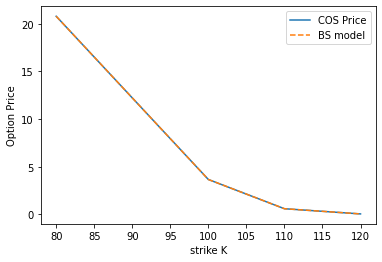

In [36]:
mainCalculation()

The line will be smoother if we add more strike and the error will decrease when we increase the expansion term N